In [2]:
import importlib
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

importlib.reload(lcwgsus)

/gpfs3/well/band/users/rbx225/GAMCC


<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

# Loat test data

In [ ]:
chromosomes = [i for i in range(1,23)]
vcfs = ["/well/band/users/rbx225/test_files/lcwgs/chr" + str(i) + ".vcf.gz" for i in chromosomes]
mafs = ["/well/band/users/rbx225/test_files/maf/maf_chr" + str(i) + ".txt" for i in chromosomes]
vcf = lcwgSus.multi_parse_vcf(chromosomes, vcfs)
af = lcwgSus.multi_read_af(chromosomes, mafs)
chip = lcwgSus.read_vcf("/well/band/users/rbx225/test_files/chip/GAM013489.vcf.gz")
chip = lcwgSus.drop_cols(chip, drop_lst = ['id', 'qual', 'filter','info','format'])

# plot_info_vs_af

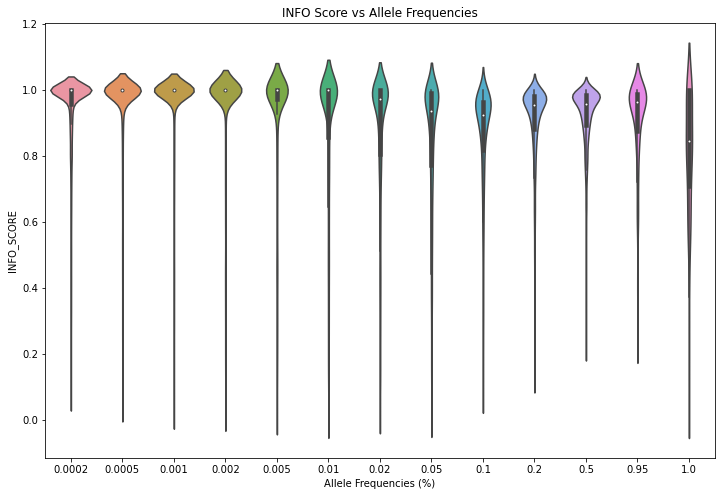

In [3]:
lcwgSus.plot_info_vs_af(vcf, af)

# sequencing_skew

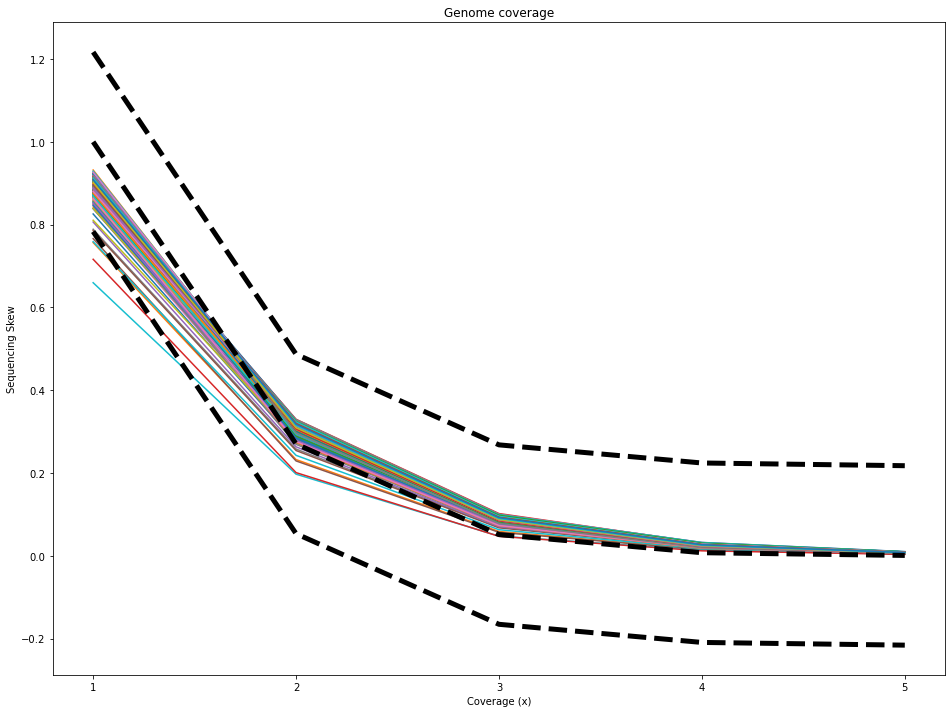

In [3]:
x = pd.read_csv('../samples.tsv', header = None, names = ['Code'])
samples = x['Code'].to_list()
ary_lst = []
for i in samples:
    ary_lst.append(np.loadtxt("../results/coverage/subsampled_bedgraphs/" + i + "_cumsum_ary.txt"))
lcwgSus.plot_sequencing_skew(ary_lst, 0.6, save_fig = True, outdir = '../graphs/') 

In [49]:
uncoverage = pd.read_csv('results/coverage/per_chromosome_coverage/uncoverage_rate.txt', 
                         header = None, sep = '\t', names = ['Code', 'proportion of genome not covered'])
metrics = pd.read_csv('results/metrics.csv')
metrics = metrics[metrics.columns[:4]]
df = pd.merge(metrics, uncoverage, on = 'Code', how = 'left')
df['dedup_coverage'] = df['Coverage']*(1-df['Dup_Rate'])
df['sequencing skew'] = df['proportion of genome not covered']/poisson.pmf(0, mu=df['dedup_coverage'], loc=0)
df_mini = df[df['Sample_Name'].str.contains('mini')]
df_fv = df[~df['Sample_Name'].str.contains('mini')]

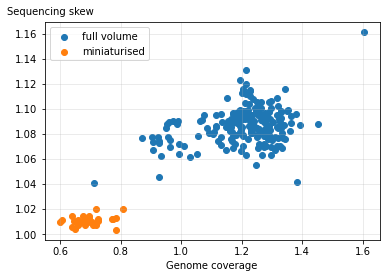

In [52]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['dedup_coverage'], df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['dedup_coverage'], df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
ax.text(x = 0.425, y = 1.175, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)
# im1 = ax.scatter(df_fv['Dup_Rate']*100, df_fv['sequencing skew'], marker = 'o', label = 'full volume', 
#               c=df_fv['dedup_coverage'], cmap=cmap1, norm=norm1)
# ax.scatter(df_mini['Dup_Rate']*100, df_mini['sequencing skew'], marker = 'x', s = 30, label = 'miniaturised', 
#               c=df_mini['dedup_coverage'], cmap=cmap1, norm=norm1)
# fig.colorbar(im1, boundaries=bounds1)

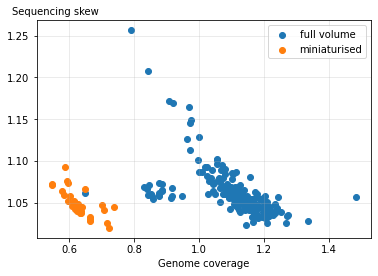

In [46]:
uncoverage = pd.read_csv('results/coverage/per_chromosome_ss_coverage/ss_uncoverage_rate.txt', 
                         header = None, sep = '\t', names = ['Code', 'proportion of genome not covered'])
uncoverage['sequencing skew'] = uncoverage['proportion of genome not covered']/poisson.pmf(0, mu=0.6, loc=0)
metrics = pd.read_csv('results/metrics.csv')
metrics = metrics[metrics.columns[:4]]
df = pd.merge(metrics, uncoverage, on = 'Code', how = 'left')
df['dedup_coverage'] = df['Coverage']*(1-df['Dup_Rate'])
df_mini = df[df['Sample_Name'].str.contains('mini')]
df_fv = df[~df['Sample_Name'].str.contains('mini')]

fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['dedup_coverage'], df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['dedup_coverage'], df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)
# im1 = ax.scatter(df_fv['Dup_Rate']*100, df_fv['sequencing skew'], marker = 'o', label = 'full volume', 
#               c=df_fv['dedup_coverage'], cmap=cmap1, norm=norm1)
# ax.scatter(df_mini['Dup_Rate']*100, df_mini['sequencing skew'], marker = 'x', s = 30, label = 'miniaturised', 
#               c=df_mini['dedup_coverage'], cmap=cmap1, norm=norm1)
# fig.colorbar(im1, boundaries=bounds1)

# ChIP data

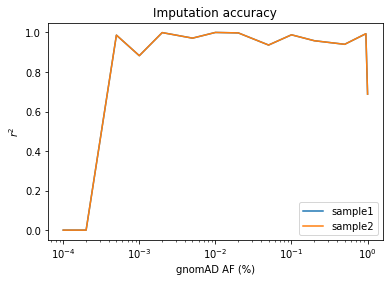

In [4]:
r2 = lcwgSus.calculate_imputation_accuracy(vcf, chip, af)
x = [r2,r2]
lcwgSus.plot_imputation_accuracy(x, label = ['sample1', 'sample2'])

# Filter allele frequencies

In [ ]:
chip_vcf = "results/chip/filtered_snps.vcf.gz"
chip_df = lcwgSus.read_vcf(chip_vcf)
colnames = lcwgSus.read_metadata(chip_vcf)

chromosomes = [i for i in range(1,23)]
mafs = ["/well/band/users/rbx225/recyclable_files/AFs/ggvp_AFs/ggvp_AF_chr" + str(i) + ".txt" for i in chromosomes]
af = lcwgSus.multi_read_af(chromosomes, mafs)
af = af.rename(columns = {'MAF': 'prop'})
chip_df = lcwgSus.calculate_af(chip_df, drop = False)

chip_res = lcwgSus.filter_afs(chip_df, af)
lcwgSus.plot_afs(chip_res[['chr', 'pos', 'ref', 'alt', 'prop']], af, save_fig = True, outdir = 'graphs/')
chip_res = chip_res.drop(columns = 'prop')
lcwgSus.save_vcf(chip_res, colnames, 'results/chip/filtered_snps.qced.vcf.gz')

# Check allele frequencies

In [4]:
chromosomes = [i for i in range(1,23)]
mafs = ["/well/band/users/rbx225/recyclable_files/AFs/ggvp_AFs/ggvp_AF_chr" + str(i) + ".txt" for i in chromosomes]
af = lcwgSus.multi_read_af(chromosomes, mafs)
af = af.rename(columns = {'MAF': 'prop'})
chip_af = pd.read_csv('/well/band/users/rbx225/recyclable_files/AFs/chip.vcf.txt', sep = '\t')
chip_af = chip_af.drop(columns = ['ID', 'QUAL','FILTER', 'INFO', 'FORMAT'])
chip_af = chip_af.rename(columns = {'#CHROM': 'chr', 'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
chip_af = lcwgSus.calculate_af(chip_af)
lcwgSus.plot_afs(chip_af, af, save_fig = False)

In [2]:
chip_af = pd.read_csv('/well/band/users/rbx225/test_files/vcf_dfs/chip_df.tsv', sep = '\t')
chip_af = chip_af.drop(columns = ['ID', 'QUAL','FILTER', 'INFO', 'FORMAT'])
chip_af = chip_af.rename(columns = {'#CHROM': 'chr', 'POS': 'pos', 'REF': 'ref', 'ALT': 'alt'})
chip_af = lcwgSus.calculate_af(chip_af)
quilt_af = pd.read_csv('/well/band/users/rbx225/test_files/vcf_dfs/quilt_df.tsv', sep = '\t', usecols = ['#CHROM', 'POS', 'REF', 'ALT', 'INFO'])
quilt_af = quilt_af.rename(columns = {'#CHROM': 'chr', 'POS': 'pos', 'REF': 'ref', 'ALT': 'alt', 'INFO': 'info'})
quilt_af = lcwgSus.extract_info(quilt_af, info_cols = ['EAF'])
quilt_af['chr'] = quilt_af['chr'].str.replace('chr', '').astype(int)
quilt_af = quilt_af.rename(columns = {'EAF': 'prop'})
lcwgSus.plot_afs(chip_af, quilt_af, save_fig = True)

# plot info vs r2

In [23]:
linker = pd.read_csv('data/metadata/sample_linker.csv', sep = ',')
samples = pd.read_csv('chip.tsv', header = None, names = ['Code'])['Code'].to_list()
fv = linker[(linker['Chip_Name'].isin(samples)) & (~linker['Sample_Name'].str.contains('mini'))]
samples_fv = fv['Seq_Name'].to_list()
panels = ['oneKG', 'oneKG_ggvp']

r2_fv, bin_count = lcwgSus.read_r2(panels, samples_fv)
r2_fv = lcwgSus.aggregate_r2(r2_fv)

chromosomes = [i for i in range(1,23)]
# vcfs = ["/well/band/users/rbx225/test_files/GAM013489_oneKG/chr" + str(i) + ".vcf.gz" for i in chromosomes]
vcfs = ["/well/band/users/rbx225/test_files/GAM013489_oneKG_ggvp_v2/chr" + str(i) + ".vcf.gz" for i in chromosomes]
vcf = lcwgSus.multi_parse_vcf(chromosomes, vcfs, info_cols = ['INFO_SCORE'])
mafs = ["/well/band/users/rbx225/GAMCC/data/oneKG_MAFs/oneKG_MAF_afr_chr" + str(i) + ".txt" for i in chromosomes]
af = lcwgSus.multi_read_af(chromosomes, mafs)
chip_df = lcwgSus.read_vcf("results/chip/filtered_snps.vcf.gz")
chip_df = chip_df[['chr', 'pos', 'ref', 'alt']]

score = lcwgSus.calculate_average_info_score(chromosomes, vcf, af, chip_df)
# info = pd.concat([r2_fv[0].reset_index(drop = True), score[['INFO_SCORE']], bin_count], axis = 1, join = 'inner')
info = pd.concat([r2_fv[1].reset_index(drop = True), score[['INFO_SCORE']], bin_count], axis = 1, join = 'inner')
lcwgSus.plot_r2_vs_info(info)

# Coverage analysis for Transfer

In [ ]:
df1 = pd.read_csv('data/metadata/seq_info.tsv', sep = '\t')

df2 = pd.read_csv('results/metrics.csv')
df2 = df2.drop(columns = ['Subsample_Uncoverage_0.6x', 'Sequencing_Skew_0.6x', 'Fragment_Size', '% > 500', 'Overlap'])
res = pd.merge(df1, df2, left_on = 'sample', right_on = 'Sample_Name', how = 'inner')
df3 = res.groupby('sample')['count'].sum().reset_index()
res = res[res['run'].str.contains('0753')].drop(columns = ['run', 'ID', 'count'])

res = pd.merge(df3, res, on = 'sample')
ss_uncoverage = pd.read_csv('results/coverage/ss_uncoverage_rate.txt', sep = '\t', header = None, names = ['Code', 'ss_uncoverage'])
uncoverage = pd.read_csv('results/coverage/uncoverage_rate.txt', sep = '\t', header = None, names = ['Code', 'uncoverage'])
coverage = pd.read_csv('results/coverage/per_sample_coverage.txt', sep = '\t', header = None, names = ['Code', 'coverage'])
res = pd.merge(uncoverage, res, on = 'Code')
res = pd.merge(coverage, res, on = 'Code')
res = pd.merge(ss_uncoverage, res, on = 'Code')
res['sequencing skew'] = res['ss_uncoverage']/poisson.pmf(0, mu=0.6, loc=0)
res['effective coverage'] = res['coverage']*(1-res['Dup_Rate'])
# res['skew'] = res['uncoverage']/poisson.pmf(0, mu=res['Coverage'], loc=0)
res['excessive coverage before'] = (res['effective coverage'] - res['uncoverage'])
res['excessive coverage after'] = (0.6 -res['ss_uncoverage'])
res['delta'] = res['excessive coverage before']
# res['loss coverage'] = res['ss_uncoverage'] - res['uncoverage']

df_mini = res[res['Sample_Name'].str.contains('mini')]
df_fv = res[~res['Sample_Name'].str.contains('mini')]
res

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['excessive coverage after'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['excessive coverage after'], label = 'miniaturised')
# ax.set_xlabel('Effective genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Effective genome coverage')
ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['loss coverage'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['loss coverage'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['skew'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['skew'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['Dup_Rate'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['Dup_Rate'], label = 'miniaturised')
ax.set_xlabel('Effective genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['effective coverage'], df_fv['count'], label = 'full volume')
ax.scatter(df_mini['effective coverage'], df_mini['count'], label = 'miniaturised')
ax.set_xlabel('Genome coverage')
# ax.text(x = 0.425, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['count'], df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['count'], df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Total yield')
ax.text(x = 0.5e7, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

In [ ]:
fig = plt.figure()
# bounds1 = np.linspace(0.5, 1.5, 11)
# colors1 = ['#20fa50', '#20de5b', '#20c267', '#20a773', '#208b7f', '#20708a', '#205496', '#2039a2', '#201dae', '#2102ba']
# cmap1 = mcolors.ListedColormap(colors1)
# norm1 = mcolors.BoundaryNorm(bounds1, cmap1.N)
# fig, ax = plt.subplots(1)
ax = plt.gca()
ax.scatter(df_fv['Dup_Rate']*100, df_fv['sequencing skew'], label = 'full volume')
ax.scatter(df_mini['Dup_Rate']*100, df_mini['sequencing skew'], label = 'miniaturised')
ax.set_xlabel('Duplication rate (%)')
ax.text(x = 6.5, y = 1.275, s = 'Sequencing skew')
ax.legend()
ax.grid(alpha = 0.3)

# Extract HLA type

In [ ]:
in_path = '/Users/sus_zhang/Desktop/Sheila/results/20240313_qc/hla.two.vcf.gz'
csv_path = "/Users/sus_zhang/Desktop/Sheila/results/20240313_qc/20240313_qc_two_fields.csv"
json_path = "/Users/sus_zhang/Desktop/Sheila/results/20240313_qc/20240313_qc_two_fields.json"
lcwgsus.extract_hla_type(in_path, csv_path, json_path)

# Recode chip indels

In [ ]:
vcf = "results/chip/vcf/chip_genotype.vcf.gz"
df = lcwgsus.convert_indel(vcf, False, '', 'results/chip/vcf/chip_recoded.vcf.gz')

# Visualise imputation calculation difference for 4 ethnic groups

Jola : 0.04745795780441272
Mandinka : 0.07241019611591074
Fula : 0.13329265847317062
Wollof : 0.10644883999224594


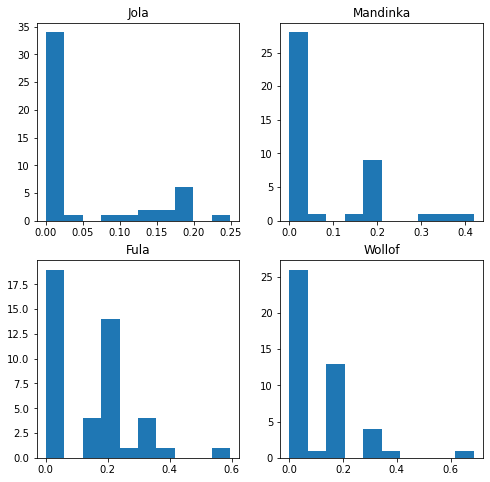

In [2]:
test = pd.read_csv('results/imputation_metrics/lc_chip/by_sample/lc.chip.typed.chr1.v.tsv', sep = '\t')
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'sample'})
tmp = test[test['AF'] == 0.002]
x = pd.merge(tmp, ethnic, on = 'sample')
ethnicities = x['ethnic'].unique()
plt.figure(figsize = (8,8))
for i, e in enumerate(ethnicities):
    y = x[x['ethnic'] == e]
    y = y[y['r2'] != -9]
    plt.subplot(2,2,i+1)
    plt.hist(y['r2'])
    plt.title(e)
    print(e, ':', y['r2'].mean())

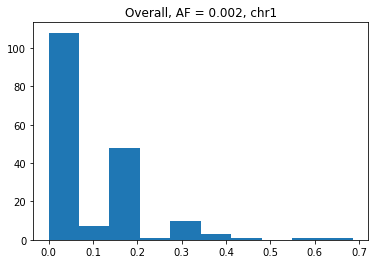

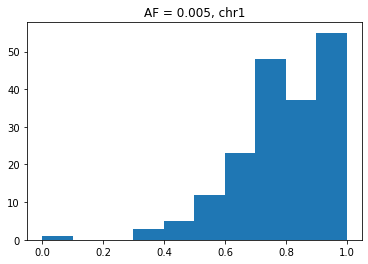

Text(0.5, 1.0, 'AF = 0.01, chr1')

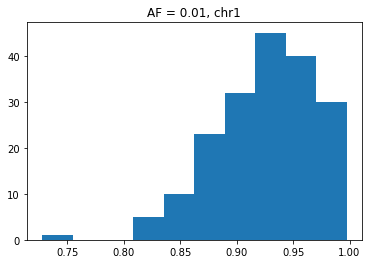

In [3]:
tmp = test[test['AF'] == 0.002]
tmp = tmp[tmp['r2'] != -9]
plt.hist(tmp['r2'])
plt.title('Overall, AF = 0.002, chr1')
plt.show()

tmp = test[test['AF'] == 0.005]
tmp = tmp[tmp['r2'] != -9]
plt.hist(tmp['r2'])
plt.title('AF = 0.005, chr1')
plt.show()

tmp = test[test['AF'] == 0.01]
tmp = tmp[tmp['r2'] != -9]
plt.hist(tmp['r2'])
plt.title('AF = 0.01, chr1')

# Plot imputation accuracy

In [4]:
chromosomes = [str(i) for i in range(1,23)]
h_lst = ["results/imputation_metrics/lc_chip/by_variant/lc.chip.typed.chr" + i + ".h.impacc.tsv" for i in chromosomes]
v_lst = ["results/imputation_metrics/lc_chip/by_sample/lc.chip.typed.chr" + i + ".v.impacc.tsv" for i in chromosomes]

h_dfs = [pd.read_csv(i, sep = '\t') for i in h_lst]
v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]

h = lcwgsus.average_impacc_by_chr(h_dfs)
v = lcwgsus.average_impacc_by_chr(v_dfs)

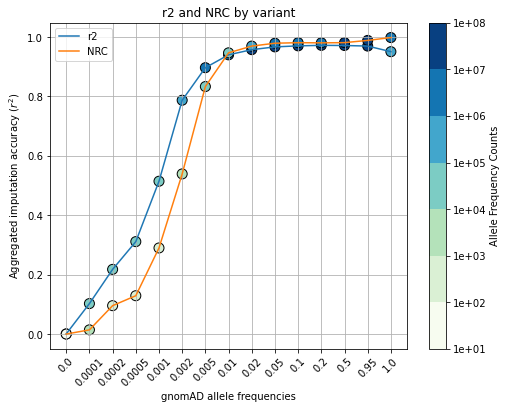

In [5]:
dfs = [h[['AF', 'r2', 'r2_AC']], h[['AF', 'NRC', 'NRC_AC']]]
lcwgsus.plot_imputation_accuracy(dfs, title = 'r2 and NRC by variant')

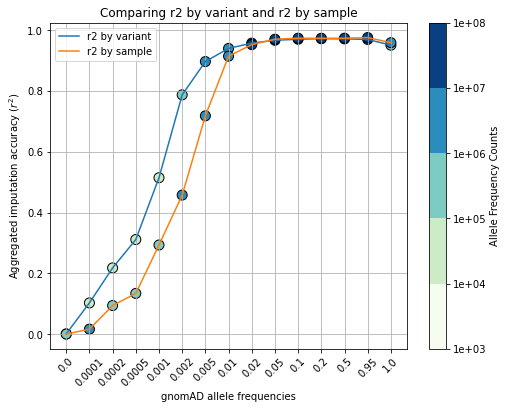

In [7]:
dfs = [h[['AF', 'r2', 'r2_AC']], v[['AF', 'r2', 'r2_AC']]]
lcwgsus.plot_imputation_accuracy(dfs, labels = ['r2 by variant', 'r2 by sample'], title = 'Comparing r2 by variant and r2 by sample')

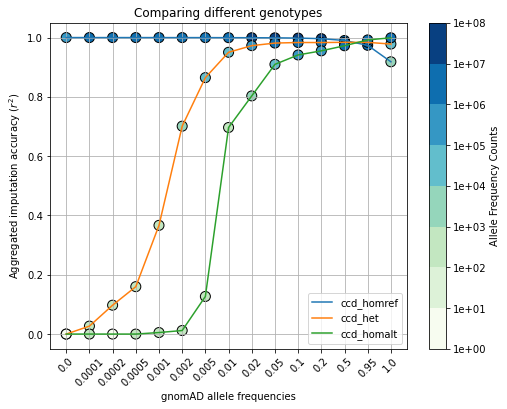

In [8]:
dfs = [h[['AF', 'ccd_homref', 'ccd_homref_AC']], h[['AF', 'ccd_het', 'ccd_het_AC']], h[['AF', 'ccd_homalt', 'ccd_homalt_AC']]]
lcwgsus.plot_imputation_accuracy(dfs, title = 'Comparing different genotypes')

# Separate samples by case_control and ethnicity

In [19]:
chip_samples = list(pd.read_table('data/sample_tsvs/samples_chip.tsv', header = None, names = ['Code'])['Code'].values)
lc_samples = list(pd.read_table('data/sample_tsvs/samples_lc.tsv', header = None, names = ['Code'])['Code'].values)

cc = pd.read_csv('data/metadata/tmp.csv', sep = ',')[['GMID', 'anon_id', 'Status_v1']].dropna()
cc = cc[cc['anon_id'].isin(chip_samples)]

eth = pd.read_csv('data/metadata/ethnic_group.csv', sep = ',')
eth = eth[eth['Chip_Name'].isin(chip_samples)]

sample_linker = pd.read_csv('data/metadata/sample_linker.csv', sep = ',')
x = sample_linker[~sample_linker['Sample_Name'].str.contains('mini')]
tmp = pd.merge(x, eth, on = 'Chip_Name')
cols = tmp['ethnic'].unique()
for i in cols:
    tmp1 = tmp[tmp['ethnic'] == i]
    tmp1[['Sample_Name']].to_csv(('data/file_lsts/samples_subset/by_ethnicity/' + i + '_samples_lc.tsv').replace(' ', '_').lower(), index = False, header = False)
    tmp1[['Chip_Name']].to_csv(('data/file_lsts/samples_subset/by_ethnicity/' + i + '_samples_hc.tsv').replace(' ', '_').lower(), index = False, header = False)

tmp = pd.merge(x, cc, left_on = 'Chip_Name', right_on = 'anon_id')
cols = tmp['Status_v1'].unique()
for i in cols:
    tmp1 = tmp[tmp['Status_v1'] == i]
    tmp1[['Sample_Name']].to_csv(('data/file_lsts/samples_subset/by_case_control/' + i + '_samples_lc.tsv').replace(' ', '_').lower(), index = False, header = False)
    tmp1[['Chip_Name']].to_csv(('data/file_lsts/samples_subset/by_case_control/' + i + '_samples_hc.tsv').replace(' ', '_').lower(), index = False, header = False)

# Violin plotting a distribution of a single variant, across runs

In [ ]:
mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'

sample_linker='data/metadata/sample_linker.csv'
c = 11
pos = 5227002

labels_lst = ['lc-oneKG', 'chip-oneKG']
source_lst = ['lc', 'chip']

lc = 'results/imputation/vcfs/oneKG/quilt.chr11.vcf.gz'
chip = 'results/chip/imputed/oneKG/emp_vcf/chr11.empiricalDose.vcf.gz'

vcf_lst = [lc, chip]

lcwgsus.visualise_single_variant(c, pos, vcf_lst, source_lst, labels_lst)

# Flip strand (Sheila)

In [ ]:
manifest = pd.read_csv("manifest.csv", sep = ',', usecols = ['Name', 'Chromosome', 'Position', 'SNP', 'ILMN Strand', 'Customer Strand'], 
                       dtype = {
                           'Name': str,
                           'Chromosome': str,
                           'Position': int,
                           'SNP': str,
                           'ILMN Strand': str,
                           'Customer Strand': str
                       })
manifest = manifest[manifest['Chromosome'] == '6']
manifest['Chromosome'] = manifest['Chromosome'].astype(int)
manifest = manifest.sort_values(by = ['Chromosome', 'Position'])

strand = pd.read_csv('GDA-8v1-0_A1-b37.Ilmn.strand', sep = '\t', header = None, 
                     names = ['ID', 'Chromosome', 'Position', 'Score', 'Strand', 'SNP'],
                    dtype = {
                        'Chromosome': str
                    })
strand = strand[strand['Chromosome'] == '6']
strand['Chromosome'] = strand['Chromosome'].astype(int)
strand = strand.sort_values(by = ['Chromosome', 'Position'])
strand = pd.merge(strand, manifest[['Chromosome', 'Position', 'ILMN Strand', 'Customer Strand']], on = ['Chromosome', 'Position'])
strand = strand.drop(columns = ['Score'])
strand.columns = ['ID', 'chr', 'pos', 'Strand', 'SNP', 'ILMN Strand', 'Customer Strand']

vcf = lcwgsus.read_vcf('restricted.chr6.vcf.gz')
vcf = vcf[(vcf['ref'] != 'I') & (vcf['ref'] != 'D') & (vcf['alt'] != '.')]

metadata = lcwgsus.read_metadata('restricted.chr6.vcf.gz')

In [ ]:
merged = pd.merge(vcf, strand, on = ['chr', 'pos', 'ID']).drop_duplicates(subset = ['chr', 'pos', 'ID'])
merged = merged.apply(lcwgsus.fix_strand, axis = 1)
merged = merged.drop(columns = ['Strand', 'SNP', 'ILMN Strand', 'Customer Strand'])
lcwgsus.save_vcf(merged, metadata, prefix = '',  outdir = '/Users/sus_zhang/Desktop/Sheila/file/redo2/', save_name = 'fixed.vcf.gz')

# Extract HLA (Sheila)

In [ ]:
directory = ['all', 'snp3', 'snp5']

# i = directory[0]
for i in directory:
    in_path = "/Users/sus_zhang/Desktop/Sheila/imputed/" + i + "/chr6.dose.vcf.gz"
    csv_path = "/Users/sus_zhang/Desktop/Sheila/imputed/" + i + "/20240421_qc_" + i + ".csv"
    json_path = "/Users/sus_zhang/Desktop/Sheila/imputed/" + i + "/20240421_qc_" + i + ".json"
    lcwgsus.extract_hla_type(in_path, csv_path, json_path)
lcwgsus.extract_hla_type(in_path, csv_path, json_path)

In [ ]:
vcf = lcwgsus.read_vcf(in_path)
vcf = vcf[vcf['ID'].str.contains('HLA')]

samples = list(vcf.columns[9:])

for i in samples:
    vcf[i] = vcf[i].apply(lcwgsus.encode_hla)

types = vcf['ID'].str.split('*').str.get(0).unique()
types.sort()
hla = pd.DataFrame({'Name': samples})
for i in types:
    hla[i + '_1'] = 0
    hla[i + '_2'] = 0
hla.set_index('Name', inplace=True)

num_type = len(types) * 2
hla_abnormal = {}
for sample in samples:
    hla_type = []
    for gene in types:
        tmp_vcf = vcf[vcf['ID'].str.contains(gene)].reset_index(drop = True)
        hla_subtype = []
        for i in range(tmp_vcf.shape[0]):
            if tmp_vcf.loc[i, sample] == 1:
                hla_subtype.append(tmp_vcf.iloc[i, 2])
            elif tmp_vcf.loc[i, sample] == 2:
                hla_subtype.append(tmp_vcf.iloc[i, 2])
                hla_subtype.append(tmp_vcf.iloc[i, 2])
            else:
                pass
        if len(hla_subtype) < 2:
            hla_subtype = hla_subtype + ['N/A'] * (2 - len(hla_subtype))
        hla_type = hla_type + hla_subtype
    if len(hla_type) == num_type:
        hla.loc[sample, :] = hla_type
    else:
        hla_abnormal[sample] = hla_type

hla.to_csv(csv_path, header = True, index = True)
if hla_abnormal != {}:
    with open(json_path, "w") as json_file:
        json.dump(hla_abnormal, json_file)

# Check HLA allele frequencies:

In [ ]:
X = alleles[alleles['Locus'] == 'A']
X = X[['frequency (GWD)', 'frequency (GGVP)', 'frequency (GAMCC)']].T
X = X.reset_index(drop = True)
X.columns = X.columns.astype(str) 
# X['others'] = 1-X.sum(axis = 1).values

# X = np.array(X.values)
y = pd.DataFrame({'population': [0, 1, 2]})
# y = np.array([0, 1, 2])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = np.array([0, 1, 2])

X = X_scaled
y = y_scaled

X = sm.add_constant(X)
model = sm.MNLogit(y, X)
result = model.fit(method = 'lbfgs', maxiter = 2, skip_hessian = True)


# Eichler SV

In [ ]:
# df = pd.read_csv('results/nonahore/eichler/manifest.5K.5percent.tsv', sep = '\t')

df = pd.read_csv('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz', sep = '\t', compression = 'gzip')
main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
df = df[df['#CHROM'].isin(main_chrs)]
df['PG_AFR_AF'] =  df['PG_INFO_AFR'].str.split(';').str.get(0).str.split('=').str.get(1).astype(float)
df = df.sort_values(by = 'POP_AFR_AF', ascending = False)
df = df[(df['SVLEN'] > 5000) & ((df['POP_AFR_AF'] >= 0.05) | (df['PG_AFR_AF'] >= 0.05))]
df = df[['#CHROM', 'POS', 'END', 'SVTYPE', 'SVLEN','ID']].reset_index(drop = True)

x = lcwgsus.read_vcf('/well/band/users/rbx225/recyclable_files/eichler_sv/variants_freeze4_sv_insdel_alt.vcf.gz')
x = x[x['ID'].isin(df['ID'])].reset_index(drop = True)
df = pd.merge(df, x[['ID', 'ref', 'alt', 'INFO']], on = ['ID'])
df['TRF'] = df['INFO'].apply(lambda x: 1 if 'REF_TRF' in x else 0)

n_hap_ary = []
info_ary = []
concordance_ary = []
est_freq_ary = []

for ix in range(len(df)):
    infile = f'results/nonahore/eichler/region{ix}/results.pickle'
    if os.path.exists(infile):
        data = read_pickle(infile)
        n_hap_ary.append(len(data['haps']))
        info_ary.append(data['info'])
        est_freq_ary.append(data['freq'])
        concordance_ary.append(data['concordance'])
    else:
        n_hap_ary.append(0)
        info_ary.append(0)
        est_freq_ary.append(0)     
        concordance_ary.append(0)
    
df['n_hap'] = n_hap_ary
df['info'] = info_ary
df['freq'] = est_freq_ary
df['concordance'] = concordance_ary

bed = pd.read_csv('data/bedgraph/GRCh38.autosomes.bed', sep = '\t', header = None)
bed.columns = ['chr', 'start', 'end']

def check_endchr(r, cutoff = 1e6):
    c = r['#CHROM']
    s = r['POS']
    endchr = bed[bed['chr'] == c]['end'].values[0]

    if s > cutoff and s < endchr - cutoff:
        r['is_endchr'] = False
    else:
        r['is_endchr'] = True
    return r
        
df1 = df.copy()
df1['is_endchr'] = False
df1 = df1.apply(check_endchr, axis = 1)

def read_eichler2(f, length_filter = 5000, af_filter = 0):
    df = pd.read_csv(f, sep = '\t', compression = 'gzip')
    main_chrs = [f'chr{i}' for i in range(1,23)] + ['X', 'Y']
    df = df[df['#CHROM'].isin(main_chrs)]
    df['PG_AFR_AF'] =  df['PG_INFO_AFR'].str.split(';').str.get(0).str.split('=').str.get(1).astype(float)
    df = df.sort_values(by = 'POP_AFR_AF', ascending = False)
    df = df[(df['SVLEN'] >= length_filter)]
    df = df.sort_values(by = df.columns[:3].tolist()).reset_index(drop = True)
    return df

eichler2 = read_eichler2('../recyclable_files/eichler_sv/variants_freeze4_sv_insdel.tsv.gz')
eichler2_subset = eichler2[['#CHROM', 'POS', 'END', 'VAL', 'MER_BKPT_NONREF']]
df1 = pd.merge(df1, eichler2_subset, on = eichler2_subset.columns[:3].tolist())
print_avg_concordance(df1)

# Nonahore

In [ ]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 4
start = 143890000
end = 144120000
flank = end - start

cov = load_region_files(regions, chromosome, start, end)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]
means, variances = normalise_by_flank(cov, start, end, flank)
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, n_iter = 50)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_sv_coverage_by_gt(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results)
plt.show()
plot_sv_heatmap(means, variances, coverage, samples, results)
plt.show()

In [ ]:
chunk_file = 'data/imputation_accessories/5Mb_chunks_for_coverage.json'
with open(chunk_file, 'r') as file:
    regions = json.load(file)

bin_size = 1000
chromosome = 4
start = 143780000
end = 143850000
flank = end - start

cov = load_region_files(regions, chromosome, start, end, flank = flank)
cov = cov[['position'] + list(cov.columns[cov.columns.str.contains('coverage')])]

bin_size = 10000
chromosome = 4
start = 143750000
end = 143900000
flank = end - start
cov1 = deresolute_windows(cov, bin_size, normalise = False)
cov = cov1.copy()

means, variances = normalise_by_flank(cov, start, end, flank, side = 'left')
samples, coverage = extract_target_cov(cov, start, end)

results = nonahore(means, variances, coverage, samples, n_iter = 50)

best_model = results['model_ary'][-1]
calling_dict = call_sv_samples(samples, results['genotypes'])

plot_sv_coverage(cov, chromosome, start, end, flank, calling_dict)
plt.show()
plot_training(results)
plt.show()
plot_sv_heatmap(means, variances, coverage, results)